# Predicting life expectancy using a regression model


### Introduction

The human lifespan has changed drastically over the past century, increasing from an average 47.3 years of age in 1900, to 78.8 by 2010 (Crimmins, 2015). Yet this impressive increase in the average life expectancy at birth does not reflect the inequalities in life expectancy which are seen across the socioeconomic divide. 

The World Health Organisation (WHO) released a dataset containing life expectancy and a large variety of health factors, such as immunization, economic, and social factors, for 193 countries between 2000-2015. We will use vaccination against HIV/AIDS mortality rate per 1000 live births, as well as BMI, and years of education to predict life expectancy using a linear regression model.


### Why these Predictors?
+ **HIV/AIDS** has been proven to shorten life expectancy by increasing the risk of other illnesses like heart disease or diabetes. This is caused by the virus weakening the immune system, making one more susceptible to illnesses and making those illnesses more likely to end in death.

+ **BMI** can be considered a proxy for health and can have a direct impact on life expectancy. As person gets further from a healthy BMI range, their life expectancy decreases.

+ **Schooling**, contrary to BMI, can increase life expectancy. It has been shown in multiple studies that people with higher levels of education tend to have longer life expectancies.


### Preliminary exploratory data analysis



In [3]:
# Import library

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(readxl)

In [4]:
### Read dataset and change column names

life_data <- read_csv("https://raw.githubusercontent.com/kjokjokjo/DSCI_100_Group_Project/main/Life_Expectancy_Data.csv") 

colnames(life_data) <- make.names(colnames(life_data))

head(life_data)

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Status = col_character()
)

See spec(...) for full column specifications.



Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,⋯,Polio,Total_expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness_1.19_years,thinness_5.9_years,Income_composition_of_resources,Schooling
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,⋯,6,8.16,65,0.1,584.25921,33736494,17.2,17.3,0.479,10.1
Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,⋯,58,8.18,62,0.1,612.69651,327582,17.5,17.5,0.476,10.0
Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,⋯,62,8.13,64,0.1,631.74498,31731688,17.7,17.7,0.470,9.9
Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,⋯,67,8.52,67,0.1,669.95900,3696958,17.9,18.0,0.463,9.8
Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,⋯,68,7.87,68,0.1,63.53723,2978599,18.2,18.2,0.454,9.5
Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,⋯,66,9.20,66,0.1,553.32894,2883167,18.4,18.4,0.448,9.2


In [5]:
### Filter the data in 2015 and Select predictors; Life Expectancy(Target), HIV/AIDS, BMI, Schooling(Predictors)

life_expectancy_select <- life_data %>%
                    filter(Year == 2015) %>% 
                    select(Life_expectancy, HIV.AIDS, BMI, Schooling)

life_expectancy_select

Life_expectancy,HIV.AIDS,BMI,Schooling
<dbl>,<dbl>,<dbl>,<dbl>
65.0,0.1,19.1,10.1
77.8,0.1,58.0,14.2
75.6,0.1,59.5,14.4
⋮,⋮,⋮,⋮
65.7,0.1,41.3,9.0
61.8,4.1,23.4,12.5
67.0,6.2,31.8,10.3


In [16]:
### The number of missing data of each predictor

colSums(is.na(life_expectancy_select))

Life_expectancy        HIV.AIDS             BMI       Schooling 
              0               0               2              10

In [12]:
### Delete missing data

life_expectancy_naomit <- na.omit(life_expectancy_select)

In [13]:
### Split dataset into training and test set

set.seed(3546)
life_expectancy_split <-initial_split(life_expectancy_naomit, prop = 0.75, strata = "Life_expectancy")
life_expectancy_training <- training(life_expectancy_split)
life_expectancy_testing <- testing(life_expectancy_split)
life_expectancy_training

Life_expectancy,HIV.AIDS,BMI,Schooling
<dbl>,<dbl>,<dbl>,<dbl>
65.0,0.1,19.1,10.1
77.8,0.1,58.0,14.2
52.4,1.9,23.3,11.4
⋮,⋮,⋮,⋮
76.0,0.1,17.5,12.6
65.7,0.1,41.3,9.0
61.8,4.1,23.4,12.5


In [14]:
### The mean of each predictor

summary(life_expectancy_training)

 Life_expectancy    HIV.AIDS           BMI          Schooling    
 Min.   :52.40   Min.   :0.1000   Min.   : 2.50   Min.   : 6.30  
 1st Qu.:66.12   1st Qu.:0.1000   1st Qu.:23.90   1st Qu.:11.12  
 Median :73.95   Median :0.1000   Median :49.25   Median :13.10  
 Mean   :72.03   Mean   :0.5977   Mean   :42.10   Mean   :13.11  
 3rd Qu.:76.85   3rd Qu.:0.3000   3rd Qu.:61.17   3rd Qu.:15.00  
 Max.   :88.00   Max.   :9.3000   Max.   :77.60   Max.   :20.40  

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


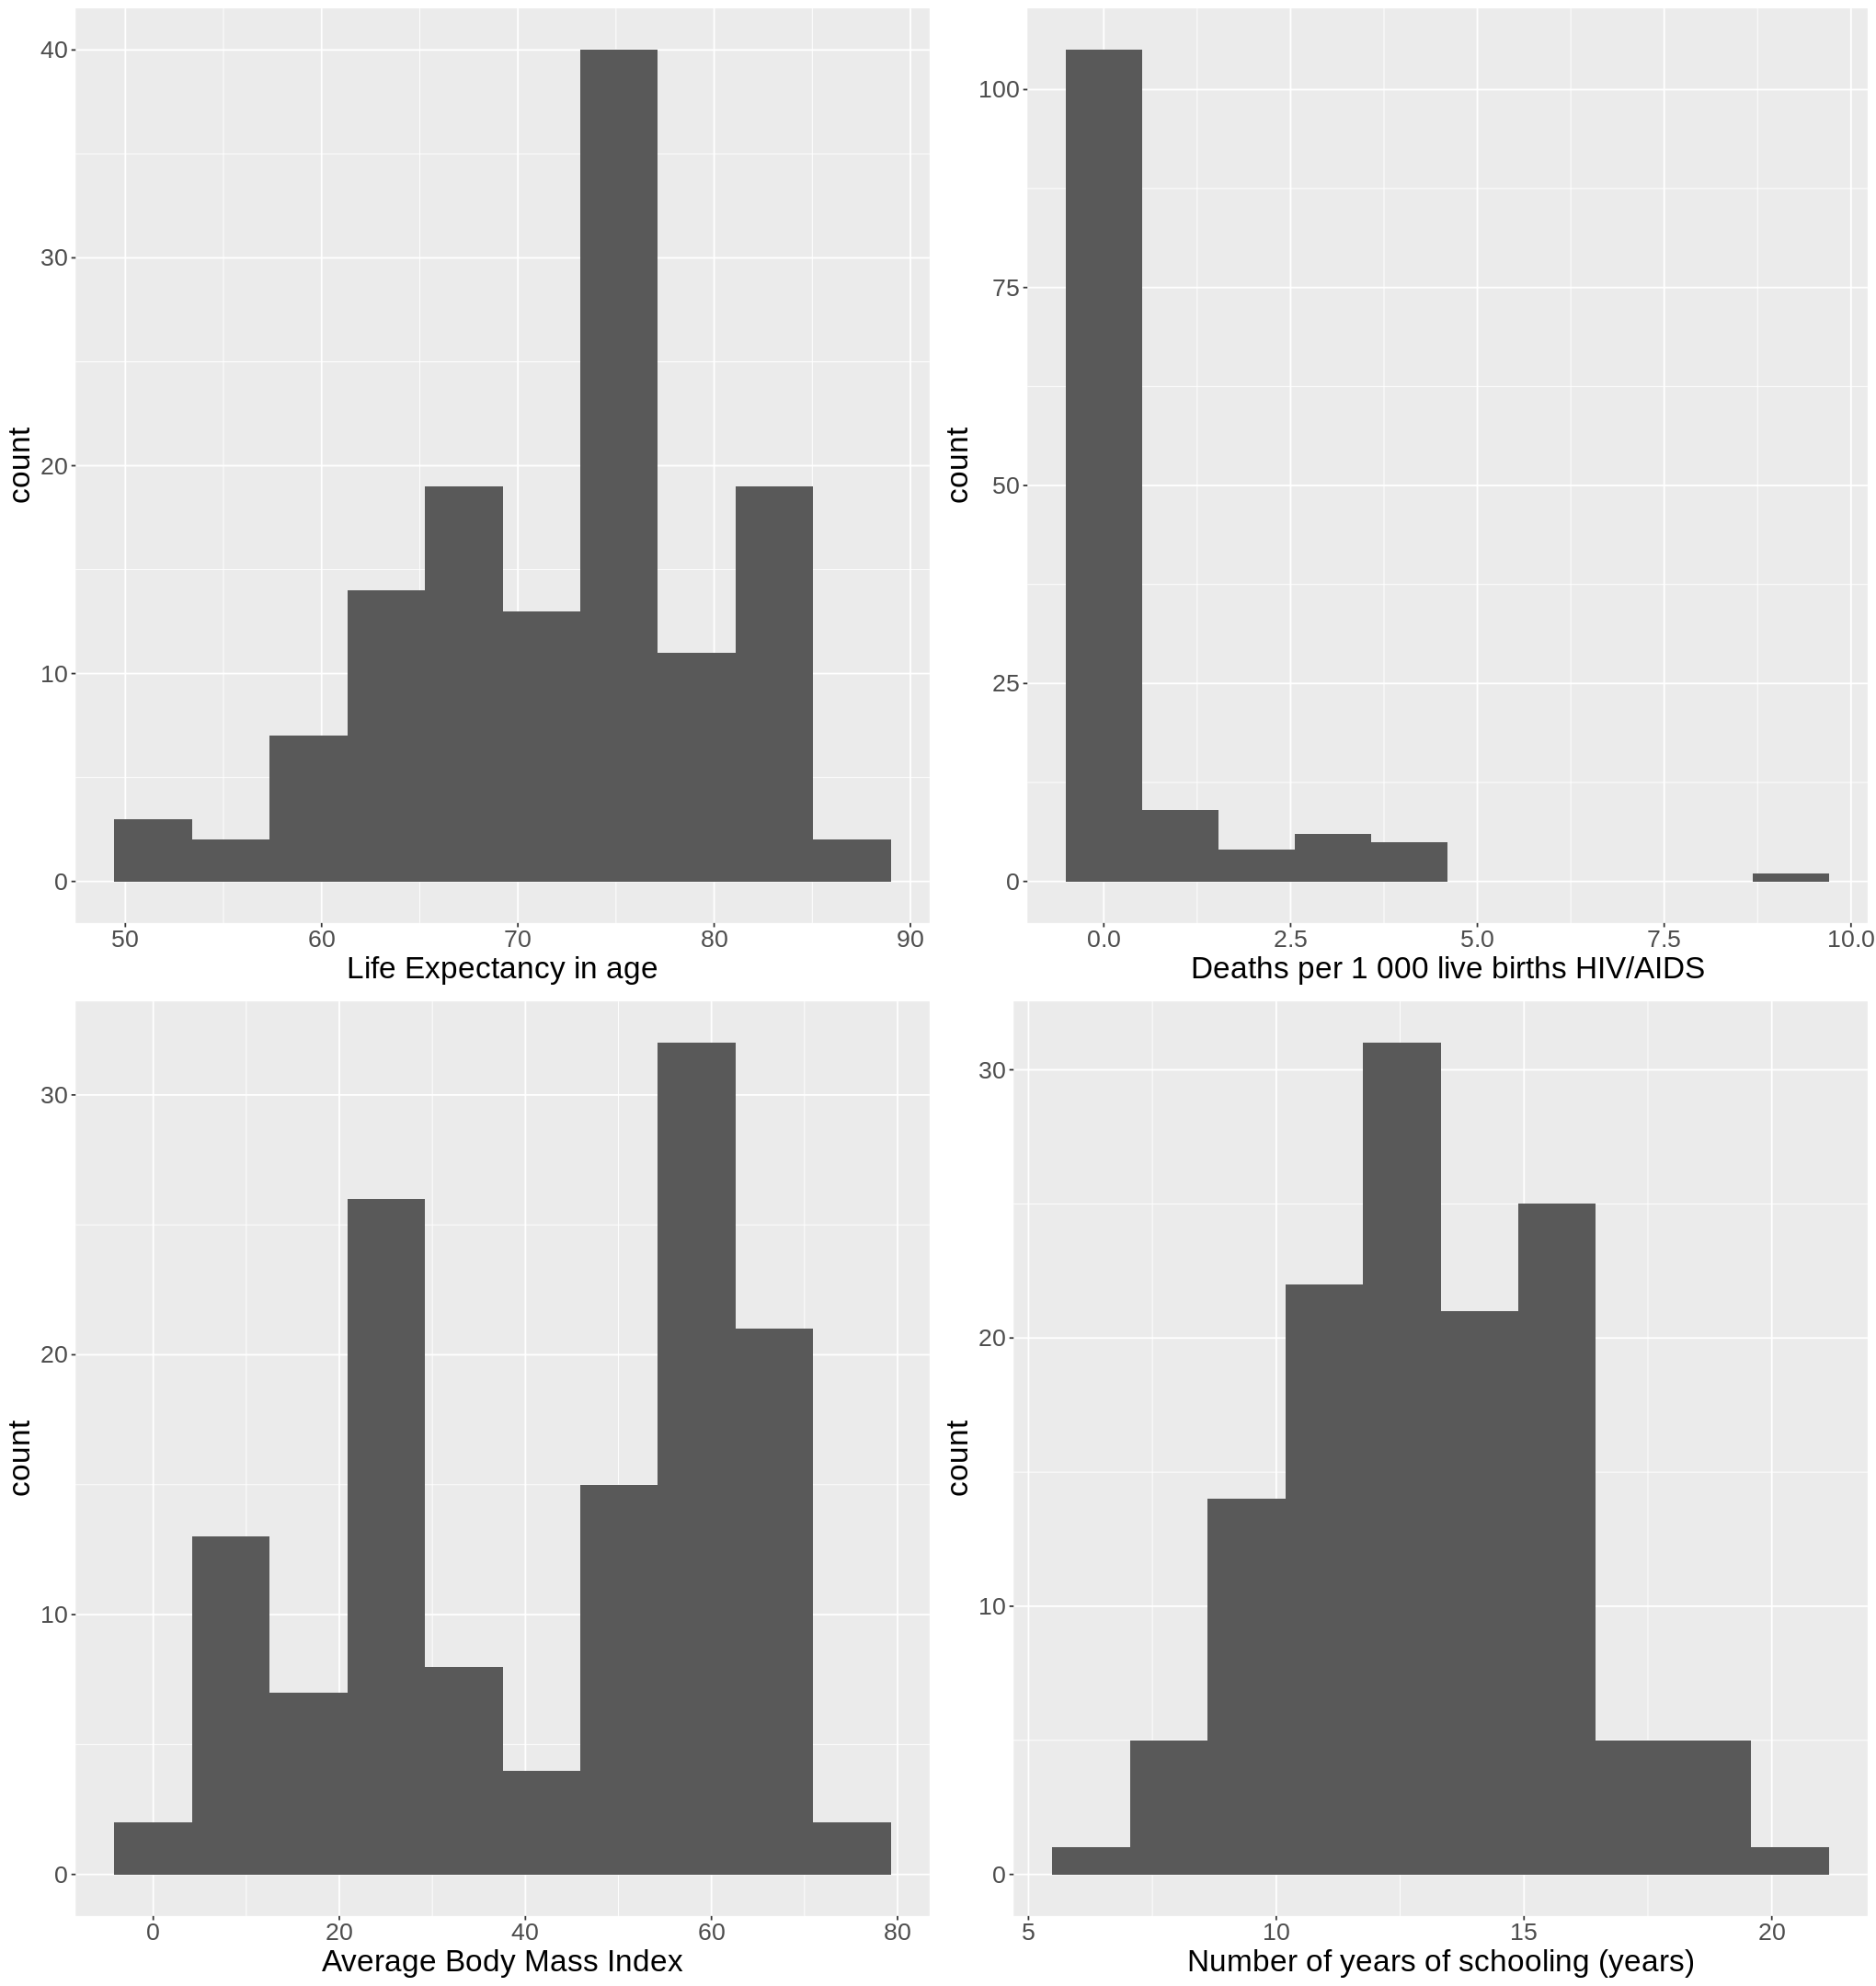

In [15]:
### Distribution of each predictor

library(cowplot)
options(repr.plot.width = 17, repr.plot.height = 18)

life_expectancy_hist <- ggplot(life_expectancy_training, aes(x = Life_expectancy)) +
    geom_histogram(bins = 10) +
    xlab("Life Expectancy in age") +
    theme(text = element_text(size = 20))

hiv_aids_hist <- ggplot(life_expectancy_training, aes(x = HIV.AIDS)) +
    geom_histogram(bins = 10) +
    xlab("Deaths per 1 000 live births HIV/AIDS") +
    theme(text = element_text(size = 20))

bmi_hist <- ggplot(life_expectancy_training, aes(x = BMI)) +
    geom_histogram(bins = 10) +
    xlab("Average Body Mass Index") +
    theme(text = element_text(size = 20))

schooling_hist <- ggplot(life_expectancy_training, aes(x = Schooling)) +
    geom_histogram(bins = 10) +
    xlab("Number of years of schooling (years)") +
    theme(text = element_text(size = 20))

plot_grid(life_expectancy_hist, hiv_aids_hist, bmi_hist, schooling_hist)

### Methods
+ After splitting the data into a test and training set, we will use a `ggpair` function to visualise the correlation between variables and the distribution of each variable we chose (HIV/AIDS, BMI, Schooling) from our data set and target variable. 

+ If the predictors have a high correlation coefficient (between ± 0.50 and ± 1), we will use them to predict the life expectancy of the countries in our test data set. 

+ Life expectancy is a continuous variable and so, after preprocessing the data using standardization, we will use either KNN or linear regression to model the relationship between variables and life expectancy–  depending on the linearity of the relationship. 

+ For a visualization of our data, we will create 2 bar charts of top 10 countries with highest life expectancy using predicted value and true value each, and compare whether the order matches. 

## Expected outcomes and significance:

We expect to find a positive relationship between schooling and life expectancy. We expect that the relationship between BMI and life expectancy, and between mortality due to HIV/Aids and life expectancy will be negative.

Determining which predicting variables have the greatest impact on increasing life expectancy would enable countries to evaluate how to invest in different sectors such as healthcare, or education, in order to increase life expectancy for its citizens. Knowing what factors affect life expectancy would also enable individuals to make decisions in their spending and political affiliation that could improve their own outcomes.

Further questions which could be investigated include looking at whether average population density negatively or positively affects life expectancy, and how much having health insurance improves life expectancy.


## References

Crimmins E. M. (2015). Lifespan and Healthspan: Past, Present, and Promise. _The Gerontologist,_ 55(6), 901–911. https://doi.org/10.1093/geront/gnv130

Novak, A., Čepar, Z., and Trunk, A. (2016). The role of expected years of schooling among life expectancy determinants. _International Journal of Innovation and Learning_. 20(1). https://www.inderscienceonline.com/doi/pdf/10.1504/IJIL.2016.076673